<a href="https://colab.research.google.com/github/Dansah2/Udacity_Tutorials/blob/main/Udacity_CNN_CatsvsDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
#read and unzip data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)


68606236/68606236 [==============================] - 3s 0us/step


In [ ]:
# list the directories with the following terminal command
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats


In [ ]:
#assign the variables with the proper file path for training and validation sets
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
# find out how many cats and dog images are in the traning and validation sets
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [ ]:
print(f"training cats: {num_cats_tr}, training dogs: {num_dogs_tr}")

print( f"validation cats: {num_cats_val}, validation dogs: {num_dogs_val}")

print(f"total training: {total_train}, total validation {total_val}")

training cats: 1000, training dogs: 1000
validation cats: 500, validation dogs: 500
total training: 2000, total validation 1000


In [ ]:
# set additional variables
BATCH_SIZE = 32
IMG_h = 150
IMG_w = 150

In [ ]:
# generate a tensorflow dataset from images files in a directory
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_h, IMG_w),
    batch_size=BATCH_SIZE,
    subset="training",
    validation_split=2/3,
    seed=123,
    shuffle=True
)

val_data = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_h, IMG_w),
    batch_size=BATCH_SIZE,
    subset="validation",
    validation_split=1/3,
    seed=123,
    shuffle=False
)

Found 2000 files belonging to 2 classes.
Using 667 files for training.
Found 1000 files belonging to 2 classes.
Using 333 files for validation.


In [ ]:
# print class names
class_Names = train_data.class_names
print(class_Names)

['cats', 'dogs']


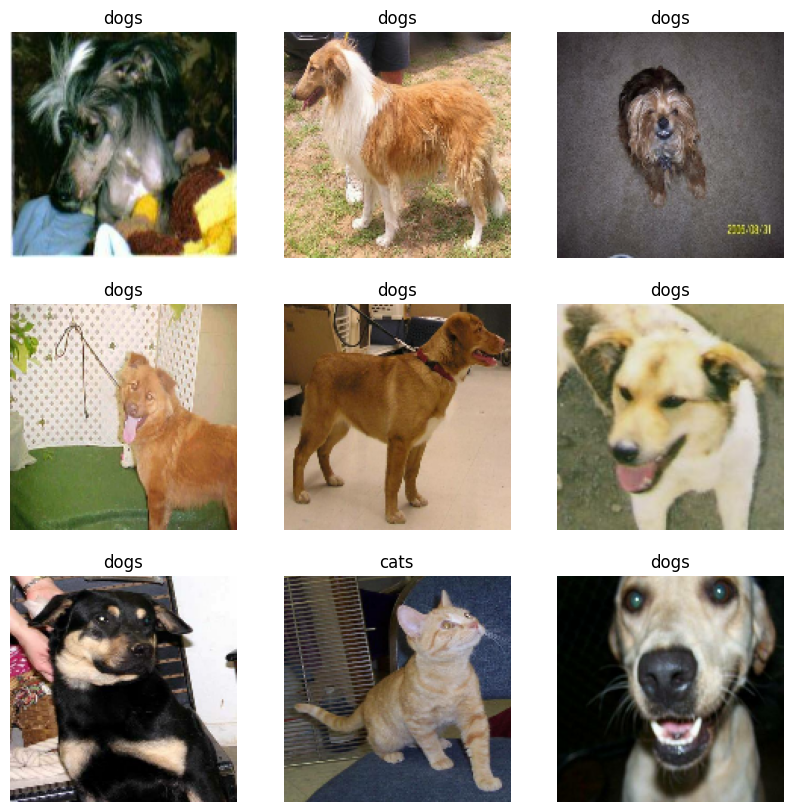

In [ ]:
# print out 9 images
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_Names[labels[i]])
    plt.axis("off")

In [ ]:
# obtain batches and print out tensor shape
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


In [ ]:
#create the model
classes = 2

model = tf.keras.models.Sequential([

    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.5, 0.2),

    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),

    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(classes, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.build(input_shape=(None, 150, 150, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 150, 150, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 150, 150, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 150, 150, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                  

In [ ]:
# early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

In [ ]:
EPOCHS = 100

history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[callback]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


21/21 [==============================] - 20s 154ms/step - loss: 0.7207 - accuracy: 0.5037 - val_loss: 0.6644 - val_accuracy: 1.0000
Epoch 2/100
21/21 [==============================] - 1s 56ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6798 - val_accuracy: 0.9550
Epoch 3/100
21/21 [==============================] - 1s 57ms/step - loss: 0.6893 - accuracy: 0.5187 - val_loss: 0.5694 - val_accuracy: 0.9670
Epoch 4/100
21/21 [==============================] - 1s 56ms/step - loss: 0.6879 - accuracy: 0.5262 - val_loss: 0.7751 - val_accuracy: 0.4174
Epoch 5/100
21/21 [==============================] - 2s 73ms/step - loss: 0.6849 - accuracy: 0.5427 - val_loss: 0.6864 - val_accuracy: 0.8168
Epoch 6/100
21/21 [==============================] - 1s 56ms/step - loss: 0.6830 - accuracy: 0.5457 - val_loss: 0.7133 - val_accuracy: 0.7297
Epoch 7/100
21/21 [==============================] - 1s 56ms/step - loss: 0.6857 - accuracy: 0.5337 - val_loss: 0.7699 - val_accuracy: 0.0270
Epoch 8/100
21/2

In [ ]:
# epoch that was stopped at
final_epoch = len(history.history['val_loss'])
print(final_epoch)

42


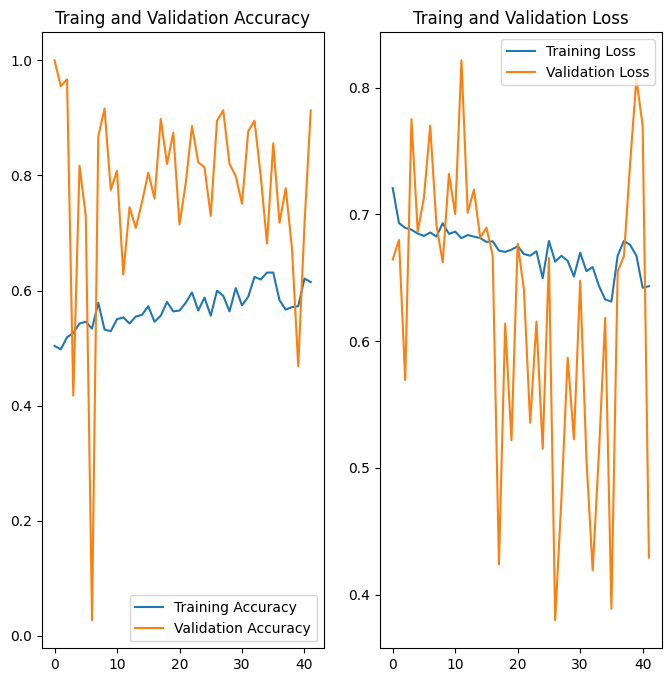

In [ ]:
# Visualize the training

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(final_epoch)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Traing and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Traing and Validation Loss')
plt.savefig('./foo.png')
plt.show()